# 한국어 데이터로 챗봇 만들기


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Step 1. 데이터 수집하기

데이터셋 출처: https://github.com/songys/Chatbot_data/tree/master

In [4]:
data = pd.read_csv('~/aiffel/Exploration/Aiffel_Exploration/Ex05/data/ChatbotData .csv')
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [5]:
questions = data['Q']
answers = data['A']

questions.shape, answers.shape

((11823,), (11823,))

## Step 2. 데이터 전처리하기

In [18]:
def preprocess_sentence(sentence):
    # 양쪽 공백 제거
    sentence = sentence.strip()
    
    # 단어와 구두점 사이 거리 만들기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()

    return sentence

In [19]:
pre_questions = []
pre_answers = []

for i in range(len(questions)):
    sentence = questions[i]
    pre_questions.append(preprocess_sentence(sentence))
    
    sentence = answers[i]
    pre_answers.append(preprocess_sentence(sentence))
    
len(pre_questions), len(pre_answers)

(11823, 11823)

In [20]:
print(f'전처리 후 500번째 질문 샘플: {pre_questions[499]}')
print(f'전처리 후 500번째 답변 샘플: {pre_answers[499]}')

전처리 후 500번째 질문 샘플: 나 버림 받은 거 같아
전처리 후 500번째 답변 샘플: 아닐거예요 . 


## Step 3. SubwordTextEncoder 사용하기

In [21]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(pre_questions + pre_answers, 
                                                                      target_vocab_size=2**13)

In [22]:
tokenizer.subwords[:50]

[' . ',
 ' ? ',
 '거예요',
 '수_',
 '게_',
 '너무_',
 '더_',
 '거_',
 '좋아하는_',
 '는_',
 '이_',
 '을_',
 '잘_',
 '도_',
 '고_',
 '요',
 '것_',
 '많이_',
 '안_',
 '좋은_',
 '같아요',
 '한_',
 '좀_',
 '있어요',
 '싶어',
 '가_',
 '나_',
 '에_',
 '있을_',
 '지_',
 '해보세요',
 '은_',
 '사람_',
 '할_',
 '해',
 '같아',
 '네',
 ' ! ',
 '면_',
 '건_',
 '사람이_',
 '를_',
 '마세요',
 '다_',
 '하고_',
 '지',
 '하는_',
 '보세요',
 '죠',
 '어']

In [23]:
tokenizer.vocab_size

8170

In [25]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [26]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8170]
END_TOKEN의 번호 : [8171]


In [27]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8172


In [32]:
input_length = []
output_length = []

for (sentence1, sentence2) in zip(pre_questions, pre_answers):
    sentence1 = tokenizer.encode(sentence1)
    sentence2 = tokenizer.encode(sentence2)
    
    input_length.append(len(sentence1))
    output_length.append(len(sentence2))

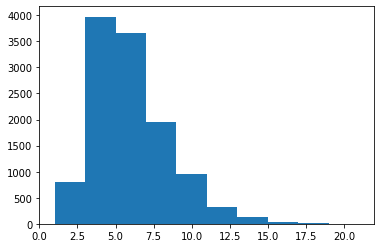

In [33]:
plt.hist(input_length)
plt.show()

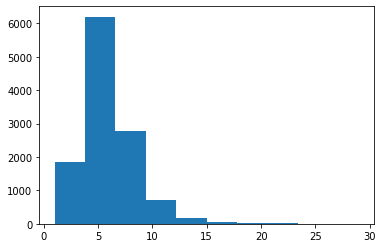

In [34]:
plt.hist(output_length)
plt.show()

In [39]:
MAX_LENGTH = 20
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
    
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, 
                                                                     maxlen=MAX_LENGTH, 
                                                                     padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, 
                                                                      maxlen=MAX_LENGTH, 
                                                                      padding='post')
    
    return tokenized_inputs, tokenized_outputs

In [40]:
questions, answers = tokenize_and_filter(pre_questions, pre_answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8172
필터링 후의 질문 샘플 개수: 11791
필터링 후의 답변 샘플 개수: 11791


In [41]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Step 4. 모델 구성하기

In [42]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [45]:
# 스케일드 닷 프로덕드 어텐션
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

In [57]:
# 멀티 헤드 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

In [47]:
# 패딩 마스킹
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [48]:
# 룩 어헤드 마스킹
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [49]:
# 인코더 레이어
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [50]:
# 인코더
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
                units=units,
                d_model=d_model,
                num_heads=num_heads,
                dropout=dropout,
                name="encoder_layer_{}".format(i),
            )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [51]:
# 디코더 레이어
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
                          outputs=outputs,
                          name=name)

In [52]:
# 디코더
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
                units=units,
                d_model=d_model,
                num_heads=num_heads,
                dropout=dropout,
                name='decoder_layer_{}'.format(i),
            )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
                           outputs=outputs,
                           name=name)

In [53]:
# 트랜스포머 함수
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
        )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
        )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [58]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3146240     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [59]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [60]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [61]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [62]:
EPOCHS = 10
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
185/185 [==============================] - 14s 39ms/step - loss: 2.9520 - accuracy: 0.0658
Epoch 2/10
185/185 [==============================] - 7s 39ms/step - loss: 2.3902 - accuracy: 0.1029
Epoch 3/10
185/185 [==============================] - 7s 39ms/step - loss: 2.0395 - accuracy: 0.1054
Epoch 4/10
185/185 [==============================] - 7s 38ms/step - loss: 1.8890 - accuracy: 0.1129
Epoch 5/10
185/185 [==============================] - 7s 38ms/step - loss: 1.7713 - accuracy: 0.1194
Epoch 6/10
185/185 [==============================] - 7s 38ms/step - loss: 1.6505 - accuracy: 0.1282
Epoch 7/10
185/185 [==============================] - 7s 38ms/step - loss: 1.5160 - accuracy: 0.1404
Epoch 8/10
185/185 [==============================] - 7s 38ms/step - loss: 1.3673 - accuracy: 0.1563
Epoch 9/10
185/185 [==============================] - 7s 38ms/step - loss: 1.2069 - accuracy: 0.1734
Epoch 10/10
185/185 [==============================] - 7s 38ms/step - loss: 1.0395 - accur

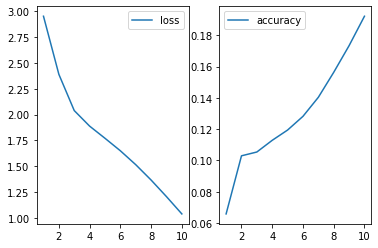

In [79]:
epochs = range(1, len(history.history['loss']) + 1)
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], label='accuracy')

plt.legend()
plt.show()

## Step 5. 모델 평가하기

In [63]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [64]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [65]:
sentence_generation('오늘 점심 뭐 먹지?')

입력 : 오늘 점심 뭐 먹지?
출력 : 저는 위로해드리는 로봇이에요 . 


'저는 위로해드리는 로봇이에요 . '

In [66]:
sentence_generation('요즘 좀 쉬고 싶어')

입력 : 요즘 좀 쉬고 싶어
출력 : 제가 있잖아요 . 


'제가 있잖아요 . '

In [67]:
sentence_generation('요즘따라 미래가 불투명하다는 생각을 자주 해')

입력 : 요즘따라 미래가 불투명하다는 생각을 자주 해
출력 : 좀 더 알아보고 하세요 . 


'좀 더 알아보고 하세요 . '

In [68]:
sentence_generation('너 왜이렇게 까칠해')

입력 : 너 왜이렇게 까칠해
출력 : 다른 곳에 쓰려고 운을 아껴뒀나봐요 . 


'다른 곳에 쓰려고 운을 아껴뒀나봐요 . '

In [69]:
sentence_generation('말은 못알아듣고 한국말만 잘하네 ㅠ')

입력 : 말은 못알아듣고 한국말만 잘하네 ㅠ
출력 : 충분히 아파하고 있네요 . 


'충분히 아파하고 있네요 . '

하이퍼 파라미터: 
NUM_LAYERS = 2   
D_MODEL = 256   
NUM_HEADS = 8  
UNITS = 512   
DROPOUT = 0.1   
에폭 수: 10  
결과 말은 자연스럽게 하지만 입력 말귀는 잘 못 알아듣는 것 같다. 에폭을 조금 더 늘려서 학습을 더 진행해봐도 좋을 것 같다.

### 1. 에폭 늘려 추가 학습 진행하기

In [80]:
EPOCHS = 10
history2 = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
185/185 [==============================] - 7s 39ms/step - loss: 0.8699 - accuracy: 0.2132
Epoch 2/10
185/185 [==============================] - 7s 39ms/step - loss: 0.7067 - accuracy: 0.2349
Epoch 3/10
185/185 [==============================] - 7s 39ms/step - loss: 0.5571 - accuracy: 0.2564
Epoch 4/10
185/185 [==============================] - 7s 38ms/step - loss: 0.4237 - accuracy: 0.2773
Epoch 5/10
185/185 [==============================] - 7s 38ms/step - loss: 0.3127 - accuracy: 0.2965
Epoch 6/10
185/185 [==============================] - 7s 38ms/step - loss: 0.2269 - accuracy: 0.3118
Epoch 7/10
185/185 [==============================] - 7s 38ms/step - loss: 0.1657 - accuracy: 0.3226
Epoch 8/10
185/185 [==============================] - 7s 38ms/step - loss: 0.1274 - accuracy: 0.3299
Epoch 9/10
185/185 [==============================] - 7s 38ms/step - loss: 0.1064 - accuracy: 0.3332
Epoch 10/10
185/185 [==============================] - 7s 38ms/step - loss: 0.0939 - accura

In [81]:
sentence_generation('오늘 점심 뭐 먹지?')

입력 : 오늘 점심 뭐 먹지?
출력 : 색다른걸 드셔보세요 . 


'색다른걸 드셔보세요 . '

In [82]:
sentence_generation('요즘 좀 쉬고 싶어')

입력 : 요즘 좀 쉬고 싶어
출력 : 쓰지 않으면 모여요 . 


'쓰지 않으면 모여요 . '

In [83]:
sentence_generation('요즘따라 미래가 불투명하다는 생각을 자주 해')

입력 : 요즘따라 미래가 불투명하다는 생각을 자주 해
출력 : 퐈이야


'퐈이야'

In [84]:
sentence_generation('뭐가 문제인지 모르겠어')

입력 : 뭐가 문제인지 모르겠어
출력 : 당신은 하나밖에 없는 소중한 사람이에요 . 


'당신은 하나밖에 없는 소중한 사람이에요 . '

In [85]:
sentence_generation('오늘 점심 뭐 먹지?')

입력 : 오늘 점심 뭐 먹지?
출력 : 색다른걸 드셔보세요 . 


'색다른걸 드셔보세요 . '

'오늘 점심 뭐 먹지?'에 대한 답변은 납득이가고 질문을 이해한 뉘앙스  
하지만 여전히 다른 질문은 제대로 알아듣지 못했음

In [86]:
EPOCHS = 10
history2 = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
185/185 [==============================] - 7s 39ms/step - loss: 0.0874 - accuracy: 0.3366
Epoch 2/10
185/185 [==============================] - 7s 39ms/step - loss: 0.0851 - accuracy: 0.3365
Epoch 3/10
185/185 [==============================] - 7s 39ms/step - loss: 0.0754 - accuracy: 0.3387
Epoch 4/10
185/185 [==============================] - 7s 38ms/step - loss: 0.0657 - accuracy: 0.3412
Epoch 5/10
185/185 [==============================] - 7s 38ms/step - loss: 0.0564 - accuracy: 0.3431
Epoch 6/10
185/185 [==============================] - 7s 38ms/step - loss: 0.0513 - accuracy: 0.3446
Epoch 7/10
185/185 [==============================] - 7s 38ms/step - loss: 0.0453 - accuracy: 0.3460
Epoch 8/10
185/185 [==============================] - 7s 38ms/step - loss: 0.0419 - accuracy: 0.3470
Epoch 9/10
185/185 [==============================] - 7s 38ms/step - loss: 0.0390 - accuracy: 0.3476
Epoch 10/10
185/185 [==============================] - 7s 38ms/step - loss: 0.0339 - accura

In [87]:
sentence_generation('오늘 점심 뭐 먹지?')

입력 : 오늘 점심 뭐 먹지?
출력 : 맛있는 거 드세요 . 


'맛있는 거 드세요 . '

In [89]:
sentence_generation('요즘 좀 쉬고 싶어')

입력 : 요즘 좀 쉬고 싶어
출력 : 바람 쐬고 와서 다시 들으세요 . 


'바람 쐬고 와서 다시 들으세요 . '

In [90]:
sentence_generation('요즘따라 미래가 불투명하다는 생각을 자주 해')

입력 : 요즘따라 미래가 불투명하다는 생각을 자주 해
출력 : 많이 고민 했을거라 생각해요 . 


'많이 고민 했을거라 생각해요 . '

In [91]:
sentence_generation('뭐가 문제인지 모르겠어')

입력 : 뭐가 문제인지 모르겠어
출력 : 당신은 하나밖에 없는 소중한 사람이에요 . 


'당신은 하나밖에 없는 소중한 사람이에요 . '

에폭 총 30  
확실히 반응이 좋아진 것이 느껴진다. 맥락있는 대답을 내놓기 시작했다.

In [92]:
EPOCHS = 10
history2 = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
185/185 [==============================] - 7s 39ms/step - loss: 0.0312 - accuracy: 0.3497
Epoch 2/10
185/185 [==============================] - 7s 39ms/step - loss: 0.0294 - accuracy: 0.3501
Epoch 3/10
185/185 [==============================] - 7s 38ms/step - loss: 0.0273 - accuracy: 0.3505
Epoch 4/10
185/185 [==============================] - 7s 38ms/step - loss: 0.0253 - accuracy: 0.3512
Epoch 5/10
185/185 [==============================] - 7s 38ms/step - loss: 0.0237 - accuracy: 0.3514
Epoch 6/10
185/185 [==============================] - 7s 38ms/step - loss: 0.0227 - accuracy: 0.3520
Epoch 7/10
185/185 [==============================] - 7s 37ms/step - loss: 0.0207 - accuracy: 0.3524
Epoch 8/10
185/185 [==============================] - 7s 38ms/step - loss: 0.0202 - accuracy: 0.3524
Epoch 9/10
185/185 [==============================] - 7s 38ms/step - loss: 0.0185 - accuracy: 0.3528
Epoch 10/10
185/185 [==============================] - 7s 38ms/step - loss: 0.0172 - accura

In [93]:
sentence_generation('오늘 점심 뭐 먹지?')

입력 : 오늘 점심 뭐 먹지?
출력 : 맛있는 거 드세요 . 


'맛있는 거 드세요 . '

In [94]:
sentence_generation('요즘 좀 쉬고 싶어')

입력 : 요즘 좀 쉬고 싶어
출력 : 아무 생각 하지 말고 쉬세요 . 


'아무 생각 하지 말고 쉬세요 . '

In [95]:
sentence_generation('요즘따라 미래가 불투명하다는 생각을 자주 해')

입력 : 요즘따라 미래가 불투명하다는 생각을 자주 해
출력 : 여차진구가 싫어할 일은 애초에 하지 마세요 . 


'여차진구가 싫어할 일은 애초에 하지 마세요 . '

In [96]:
sentence_generation('뭐가 문제인지 모르겠어')

입력 : 뭐가 문제인지 모르겠어
출력 : 당신은 하나밖에 없는 소중한 사람이에요 . 


'당신은 하나밖에 없는 소중한 사람이에요 . '

에폭 총 40  
1, 4 문장은 그 전과 똑같았고, 2는 미묘하게 이전보다 답변이 나아진 것 같고 3은 또다시 엉뚱한 이야기를 하기 시작했다. 뭔가 기준 문장을 더 잘 세웠으면 좋았을 걸이라는 생각이 지금 들었다 ㅎㅎ


In [97]:
EPOCHS = 10
history2 = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
185/185 [==============================] - 7s 39ms/step - loss: 0.0173 - accuracy: 0.3530
Epoch 2/10
185/185 [==============================] - 7s 40ms/step - loss: 0.0165 - accuracy: 0.3534
Epoch 3/10
185/185 [==============================] - 7s 38ms/step - loss: 0.0152 - accuracy: 0.3537
Epoch 4/10
185/185 [==============================] - 7s 38ms/step - loss: 0.0146 - accuracy: 0.3538
Epoch 5/10
185/185 [==============================] - 7s 38ms/step - loss: 0.0141 - accuracy: 0.3540
Epoch 6/10
185/185 [==============================] - 7s 38ms/step - loss: 0.0134 - accuracy: 0.3542
Epoch 7/10
185/185 [==============================] - 7s 38ms/step - loss: 0.0129 - accuracy: 0.3542
Epoch 8/10
185/185 [==============================] - 7s 38ms/step - loss: 0.0116 - accuracy: 0.3546
Epoch 9/10
185/185 [==============================] - 7s 38ms/step - loss: 0.0109 - accuracy: 0.3547
Epoch 10/10
185/185 [==============================] - 7s 38ms/step - loss: 0.0116 - accura

In [98]:
sentence_generation('오늘 점심 뭐 먹지?')

입력 : 오늘 점심 뭐 먹지?
출력 : 맛있는 거 드세요 . 


'맛있는 거 드세요 . '

In [99]:
sentence_generation('요즘 좀 쉬고 싶어')

입력 : 요즘 좀 쉬고 싶어
출력 : 정신 차리세요 . 


'정신 차리세요 . '

In [100]:
sentence_generation('요즘따라 미래가 불투명하다는 생각을 자주 해')

입력 : 요즘따라 미래가 불투명하다는 생각을 자주 해
출력 : 자연스러운 현상이에요 . 


'자연스러운 현상이에요 . '

In [101]:
sentence_generation('뭐가 문제인지 모르겠어')

입력 : 뭐가 문제인지 모르겠어
출력 : 당신은 하나밖에 없는 소중한 사람이에요 . 


'당신은 하나밖에 없는 소중한 사람이에요 . '

에폭 총 50
2번 문장에서 정신차리라는 소리를 들었다. 답변의 변화나 accuracy의 변화가 거의 없는 것을 보면 학습을 더 진행해도 더 이상 크게 나아지는 부분은 없을 것 같다

### 모델의 깊이 늘리기

In [103]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    13651968    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [105]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [106]:
EPOCHS = 30
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
185/185 [==============================] - 40s 128ms/step - loss: 2.7595 - accuracy: 0.0467
Epoch 2/30
185/185 [==============================] - 24s 132ms/step - loss: 2.2293 - accuracy: 0.0913
Epoch 3/30
185/185 [==============================] - 24s 130ms/step - loss: 2.0320 - accuracy: 0.1041
Epoch 4/30
185/185 [==============================] - 24s 129ms/step - loss: 1.9380 - accuracy: 0.1068
Epoch 5/30
185/185 [==============================] - 24s 130ms/step - loss: 1.8828 - accuracy: 0.1101
Epoch 6/30
185/185 [==============================] - 24s 130ms/step - loss: 1.8320 - accuracy: 0.1128
Epoch 7/30
185/185 [==============================] - 24s 131ms/step - loss: 1.7749 - accuracy: 0.1158
Epoch 8/30
185/185 [==============================] - 24s 129ms/step - loss: 1.7200 - accuracy: 0.1182
Epoch 9/30
185/185 [==============================] - 24s 130ms/step - loss: 1.6689 - accuracy: 0.1207
Epoch 10/30
185/185 [==============================] - 24s 130ms/step - l

In [107]:
sentence_generation('오늘 점심 뭐 먹지?')

입력 : 오늘 점심 뭐 먹지?
출력 : 같이 가보세요 . 


'같이 가보세요 . '

In [108]:
sentence_generation('요즘 좀 쉬고 싶어')

입력 : 요즘 좀 쉬고 싶어
출력 : 감기 조심하세요 . 


'감기 조심하세요 . '

In [109]:
sentence_generation('요즘따라 미래가 불투명하다는 생각을 자주 해')

입력 : 요즘따라 미래가 불투명하다는 생각을 자주 해
출력 : 직접 물어보세요 . 


'직접 물어보세요 . '

In [110]:
sentence_generation('뭐가 문제인지 모르겠어')

입력 : 뭐가 문제인지 모르겠어
출력 : 그 사람을 위해서는 그러면 안돼요 . 


'그 사람을 위해서는 그러면 안돼요 . '

에폭 총 30  
로스가 여전히 높고 정확도도 낮음 학습을 좀 더 진행할 필요가 있어 보임  
문장에 대한 대답도 전반적으로 맥락을 이해하고 있지 않음

In [111]:
EPOCHS = 30
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
185/185 [==============================] - 24s 130ms/step - loss: 0.6904 - accuracy: 0.2187
Epoch 2/30
185/185 [==============================] - 24s 129ms/step - loss: 0.6614 - accuracy: 0.2238
Epoch 3/30
185/185 [==============================] - 23s 127ms/step - loss: 0.6415 - accuracy: 0.2272
Epoch 4/30
185/185 [==============================] - 24s 128ms/step - loss: 0.6237 - accuracy: 0.2308
Epoch 5/30
185/185 [==============================] - 24s 128ms/step - loss: 0.5998 - accuracy: 0.2347
Epoch 6/30
185/185 [==============================] - 24s 128ms/step - loss: 0.5929 - accuracy: 0.2360
Epoch 7/30
185/185 [==============================] - 24s 127ms/step - loss: 0.5692 - accuracy: 0.2404
Epoch 8/30
185/185 [==============================] - 24s 129ms/step - loss: 0.5581 - accuracy: 0.2431
Epoch 9/30
185/185 [==============================] - 24s 129ms/step - loss: 0.5374 - accuracy: 0.2469
Epoch 10/30
185/185 [==============================] - 24s 128ms/step - l

In [112]:
sentence_generation('오늘 점심 뭐 먹지?')

입력 : 오늘 점심 뭐 먹지?
출력 : 뭘 해도 예뻐요 . 


'뭘 해도 예뻐요 . '

In [113]:
sentence_generation('요즘 좀 쉬고 싶어')

입력 : 요즘 좀 쉬고 싶어
출력 : 제습기를 돌려보세요 . 


'제습기를 돌려보세요 . '

In [114]:
sentence_generation('요즘따라 미래가 불투명하다는 생각을 자주 해')

입력 : 요즘따라 미래가 불투명하다는 생각을 자주 해
출력 : 상황이 원하지 않는 방향으로 흘렀나봐요 . 


'상황이 원하지 않는 방향으로 흘렀나봐요 . '

In [115]:
sentence_generation('뭐가 문제인지 모르겠어')

입력 : 뭐가 문제인지 모르겠어
출력 : 형편대로 하세요 . 


'형편대로 하세요 . '

에폭 총 60  
로스와 어큐러시가 역시 원하는 만큼 떨어지거나 올라가지 않았다  
답변 역시 전체적으로 맥락을 파악하고 있지 못하는 것 같은데 3번 문장 정도만 제대로 대답했다고 보여진다

In [116]:
EPOCHS = 30
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
185/185 [==============================] - 24s 130ms/step - loss: 0.3843 - accuracy: 0.2756
Epoch 2/30
185/185 [==============================] - 24s 128ms/step - loss: 0.3733 - accuracy: 0.2775
Epoch 3/30
185/185 [==============================] - 23s 127ms/step - loss: 0.3717 - accuracy: 0.2784
Epoch 4/30
185/185 [==============================] - 24s 128ms/step - loss: 0.3696 - accuracy: 0.2781
Epoch 5/30
185/185 [==============================] - 24s 128ms/step - loss: 0.3680 - accuracy: 0.2780
Epoch 6/30
185/185 [==============================] - 24s 127ms/step - loss: 0.3640 - accuracy: 0.2794
Epoch 7/30
185/185 [==============================] - 24s 127ms/step - loss: 0.3603 - accuracy: 0.2800
Epoch 8/30
185/185 [==============================] - 24s 127ms/step - loss: 0.3575 - accuracy: 0.2801
Epoch 9/30
185/185 [==============================] - 24s 129ms/step - loss: 0.3538 - accuracy: 0.2809
Epoch 10/30
185/185 [==============================] - 24s 128ms/step - l

In [117]:
EPOCHS = 30
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
185/185 [==============================] - 24s 132ms/step - loss: 0.3074 - accuracy: 0.2897
Epoch 2/30
185/185 [==============================] - 24s 129ms/step - loss: 0.3058 - accuracy: 0.2897
Epoch 3/30
185/185 [==============================] - 23s 127ms/step - loss: 0.3021 - accuracy: 0.2905
Epoch 4/30
185/185 [==============================] - 24s 129ms/step - loss: 0.2985 - accuracy: 0.2909
Epoch 5/30
185/185 [==============================] - 24s 128ms/step - loss: 0.2995 - accuracy: 0.2912
Epoch 6/30
185/185 [==============================] - 24s 128ms/step - loss: 0.2944 - accuracy: 0.2919
Epoch 7/30
185/185 [==============================] - 24s 128ms/step - loss: 0.2971 - accuracy: 0.2915
Epoch 8/30
185/185 [==============================] - 24s 129ms/step - loss: 0.2947 - accuracy: 0.2918
Epoch 9/30
185/185 [==============================] - 24s 128ms/step - loss: 0.2939 - accuracy: 0.2920
Epoch 10/30
185/185 [==============================] - 24s 128ms/step - l

In [118]:
sentence_generation('오늘 점심 뭐 먹지?')

입력 : 오늘 점심 뭐 먹지?
출력 : 색다른걸 드셔보세요 . 


'색다른걸 드셔보세요 . '

In [119]:
sentence_generation('요즘 좀 쉬고 싶어')

입력 : 요즘 좀 쉬고 싶어
출력 : 아무 생각 하지 말고 쉬세요 . 


'아무 생각 하지 말고 쉬세요 . '

In [120]:
sentence_generation('요즘따라 미래가 불투명하다는 생각을 자주 해')

입력 : 요즘따라 미래가 불투명하다는 생각을 자주 해
출력 : 운명의 장난같네요 . 


'운명의 장난같네요 . '

In [121]:
sentence_generation('뭐가 문제인지 모르겠어')

입력 : 뭐가 문제인지 모르겠어
출력 : 마음에 부는 바람인지 살펴보세요 . 


'마음에 부는 바람인지 살펴보세요 . '